In [1]:
!pip install tokenizers
!pip install tokenizers torch matplotlib scikit-learn
!pip install torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 63.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 56.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 58.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
dataset_directory = "/content/drive/MyDrive/PyACode_Completion/Dataset"
tokenizer_directory="/content/drive/MyDrive/PyACode_Completion/Trained _Tokenizer/tokenizer.json"
GRU_model_directory="/content/drive/MyDrive/PyACode_Completion/GRU/trained_model.pth"
GRU_training_history_directory="/content/drive/MyDrive/PyACode_Completion/GRU/training_history.pkl"
LSTM_model_directory="/content/drive/MyDrive/PyACode_Completion/LSTM/trained_model.pth"
LSTM_training_history_directory="/content/drive/MyDrive/PyACode_Completion/LSTM/training_history.pkl"

In [3]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from tokenizers import Tokenizer
from tokenizers.models import WordLevel
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.trainers import WordLevelTrainer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import re

In [4]:
# Checking GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
def preprocess_code(code):
    return remove_comments_and_docstrings(code)

# Function to remove comments and docstrings
def remove_comments_and_docstrings(code):
    code = re.sub(r'#.*', '', code)  # Removing single-line comments
    code = re.sub(r'\'\'\'(.*?)\'\'\'', '', code, flags=re.DOTALL)  # Removing docstrings (single quotes)
    code = re.sub(r'\"\"\"(.*?)\"\"\"', '', code, flags=re.DOTALL)  # Removing docstrings (double quotes)
    return re.sub(r'\n+', '\n', code)  # Normalizing newlines


In [ ]:
# Function to loading Python files from a given directory
def load_python_files(directory, max_files=1000):
    code_snippets = []
    file_count = 0  # Counter to track the number of files loaded

    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(".py"):  # Only process the Python files
                if file_count >= max_files:  # Stop if we've loaded the max number of files
                    break

                file_path = os.path.join(root, file)
                try:
                    with open(file_path, "r", encoding="latin-1", errors='ignore') as f:
                        code = f.read()
                        cleaned_code = preprocess_code(code)
                        code_snippets.append(cleaned_code)
                        file_count += 1
                except Exception as e:
                    print(f"Error processing file {file}: {e}")
                    continue  # Skip this file if there's an error and continue with the next one

        if file_count >= max_files:
            break  # Break the outer loop if we've loaded enough files

    return code_snippets


In [ ]:

# Load and preprocess dataset
dataset = load_python_files(dataset_directory)
print("Dataset loaded successfully. Total files:", len(dataset))

Dataset loaded successfully. Total files: 1000


In [ ]:
print(dataset[5])


from __future__ import unicode_literals
from django.db import migrations, models
class Migration(migrations.Migration):
    dependencies = [
        ('workshops', '0076_auto_20160208_0934'),
    ]
    operations = [
        migrations.AddField(
            model_name='invoicerequest',
            name='paid_date',
            field=models.DateField(blank=True, help_text='YYYY-MM-DD', null=True, verbose_name='Date invoice was paid'),
        ),
        migrations.AddField(
            model_name='invoicerequest',
            name='sent_date',
            field=models.DateField(blank=True, help_text='YYYY-MM-DD', null=True, verbose_name='Date invoice was sent out'),
        ),
        migrations.AlterField(
            model_name='invoicerequest',
            name='full_address',
            field=models.TextField(help_text='e.g. Dr. Jane Smith; University of Florida Ecology Department; 123 University Way; Gainesville, FL 32844', verbose_name='Full address to invoice'),
        ),
     

In [ ]:
tokenizer = Tokenizer(WordLevel(unk_token="[UNK]"))
tokenizer.pre_tokenizer = Whitespace()
trainer = WordLevelTrainer(special_tokens=["[UNK]", "[PAD]", "[CLS]", "[SEP]", "[MASK]"])
tokenizer.train_from_iterator(dataset, trainer)

# Save tokenizer
tokenizer.save("/content/drive/MyDrive/PyACode_Completion/Trained Tokenizer/tokenizer.json")


In [5]:
#load the tokenizer
from tokenizers import Tokenizer
tokenizer = Tokenizer.from_file(tokenizer_directory)

In [6]:
# Get the vocabulary
len(tokenizer.get_vocab())

12847

In [ ]:
# Function to create sequences for training and validation
def create_sequences(tokenizer, texts, seq_length=50, val_ratio=0.2):
    tokenized = [tokenizer.encode(t).ids for t in texts]
    all_tokens = [token for tokens in tokenized for token in tokens]

    print(f"Total tokens after tokenization: {len(all_tokens)}")

    X, y = [], []
    for i in range(len(all_tokens) - seq_length):
        X.append(all_tokens[i:i+seq_length])
        y.append(all_tokens[i+seq_length])

    # Convert to tensors
    X = torch.tensor(X, dtype=torch.long)
    y = torch.tensor(y, dtype=torch.long)

    # Split into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=val_ratio, random_state=42)

    return X_train, X_val, y_train, y_val


In [ ]:
# Preparing training and validation data
X_train, X_val, y_train, y_val = create_sequences(tokenizer, dataset, seq_length=50, val_ratio=0.2)

# Moving data to GPU if available
X_train, y_train = X_train.to(device), y_train.to(device)
X_val, y_val = X_val.to(device), y_val.to(device)


print(f"Training Samples: {len(X_train)}, Validation Samples: {len(X_val)}")
print(f"Training Samples: {len(y_train)}, Validation Samples: {len(y_val)}")
print(f"x_train: {X_train}")
print(f"y_train: {y_train}")

Total tokens after tokenization: 1405743
Training Samples: 1124554, Validation Samples: 281139
Training Samples: 1124554, Validation Samples: 281139
x_train: tensor([[  83,   74,    5,  ...,   74,    5,  161],
        [ 638,   26, 1217,  ..., 2906,   68,    9],
        [  13,    5,   22,  ...,    9,   16,    5],
        ...,
        [  29,    7,    6,  ..., 2674,   51,    6],
        [   5,   13,    5,  ...,   14,   12,   28],
        [   9,  169,    8,  ...,  300,  128,    9]], device='cuda:0')
y_train: tensor([  26, 2909,   11,  ...,   30,    7,   48], device='cuda:0')


In [ ]:
print(y_train)

tensor([  26, 2909,   11,  ...,   30,    7,   48], device='cuda:0')


In [7]:
import torch
import torch.nn as nn

# LSTM model
class CodePredictor(nn.Module):
    def __init__(self, vocab_size, embedding_dim=512, hidden_dim=512, num_layers=2, dropout=0.3):
        super(CodePredictor, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, vocab_size)


    def forward(self, x):
        x = self.embedding(x)
        lstm_out, _ = self.lstm(x)
        x = self.fc(lstm_out[:, -1, :]) # Geting the last output of the LSTM sequence
        return x



#GRU Model
"""
class CodePredictor(nn.Module):
    def __init__(self, vocab_size, embedding_dim=512, hidden_dim=512, num_layers=2, dropout=0.3):
        super(CodePredictor, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_dim, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim , vocab_size)

    def forward(self, x):
        x = self.embedding(x)
        gru_out, _ = self.gru(x)
        x= self.fc(gru_out[:, -1, :])
        return x

"""




'\nclass CodePredictor(nn.Module):\n    def __init__(self, vocab_size, embedding_dim=512, hidden_dim=512, num_layers=2, dropout=0.3):\n        super(CodePredictor, self).__init__()\n        self.embedding = nn.Embedding(vocab_size, embedding_dim)\n        self.gru = nn.GRU(embedding_dim, hidden_dim, num_layers=num_layers, batch_first=True, dropout=dropout)\n        self.fc = nn.Linear(hidden_dim , vocab_size)\n\n    def forward(self, x):\n        x = self.embedding(x)\n        gru_out, _ = self.gru(x)\n        x= self.fc(gru_out[:, -1, :])\n        return x\n\n'

In [8]:
# Model setup
vocab_size = len(tokenizer.get_vocab())
print(f"Vocabulary Size: {vocab_size}")
model = CodePredictor(vocab_size).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)



Vocabulary Size: 12847


In [ ]:

# Function to evaluate model on validation set
def evaluate_model(model, X_val, y_val, criterion, batch_size):
    model.eval()
    total_loss, correct, total = 0, 0, 0

    with torch.no_grad():
        for i in range(0, len(X_val), batch_size):
            batch_X = X_val[i:i+batch_size].to(device)
            batch_y = y_val[i:i+batch_size].to(device)

            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            total_loss += loss.item()

            # Computing validation accuracy
            predictions = torch.argmax(outputs, dim=1)
            correct += (predictions == batch_y).sum().item()
            total += batch_y.size(0)

    val_loss = total_loss / (len(X_val) / batch_size)
    val_accuracy = correct / total
    return val_loss, val_accuracy

In [ ]:
def compute_perplexity(loss):
    return torch.exp(loss)

In [ ]:
# Training Loop

epochs = 15
batch_size = 128
train_losses, val_losses, val_accuracies = [], [], []
train_perplexities, val_perplexities = [], []
train_accuracies = []

from tqdm import tqdm

# Training loop with tqdm progress bar
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    correct_train = 0
    total_train = 0

    # Creating a tqdm progress bar
    for i in tqdm(range(0, len(X_train), batch_size), desc=f"Epoch {epoch+1}/{epochs}", unit="batch"):
        batch_X = X_train[i:i+batch_size].to(device)
        batch_y = y_train[i:i+batch_size].to(device)

        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        # Calculating training accuracy
        predictions = torch.argmax(outputs, dim=1)
        correct_train += (predictions == batch_y).sum().item()
        total_train += batch_y.size(0)

    # Computing training accuracy and validation loss and accuracy
    train_loss = epoch_loss / (len(X_train) / batch_size)
    train_accuracy = correct_train / total_train
    val_loss, val_accuracy = evaluate_model(model, X_val, y_val, criterion, batch_size)

    # Computing perplexities
    train_perplexity = compute_perplexity(torch.tensor(train_loss))
    val_perplexity = compute_perplexity(torch.tensor(val_loss))

    # Save losses and perplexities
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    train_perplexities.append(train_perplexity.item())
    val_perplexities.append(val_perplexity.item())
    train_accuracies.append(train_accuracy)

    # Print results with flush to ensure immediate output
    print(f"Epoch {epoch+1}/{epochs} -> "
          f"Train Loss: {train_loss:.4f}, "
          f"Train Accuracy: {train_accuracy:.4f}, "
          f"Train Perplexity: {train_perplexity:.4f}, "
          f"Val Loss: {val_loss:.4f}, "
          f"Val Accuracy: {val_accuracy:.4f}, "
          f"Val Perplexity: {val_perplexity:.4f}", flush=True)




In [ ]:
import pickle

# Saving the training history
with open(LSTM_training_history_directory, "wb") as f:
    pickle.dump({
        "train_losses": train_losses,
        "val_losses": val_losses,
        "val_accuracies": val_accuracies,
        "train_perplexities": train_perplexities,
        "val_perplexities": val_perplexities,
        "train_accuracies": train_accuracies  # Save training accuracy
    }, f)

print("Training history saved successfully.")


In [ ]:
# Saving the trained model
torch.save(model.state_dict(), LSTM_model_directory)

print("Model saved successfully.")

In [9]:
# Loading the model weights, specifying the CPU as the map location
model.load_state_dict(torch.load(LSTM_model_directory, map_location=torch.device('cpu')))
model.to(device)  # Moving the model to the current device (CPU in this case)
model.eval()

print("Model loaded successfully.")

<ipython-input-9-624b216ac64a>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(LSTM_model_directory, map_location=torch.device('cpu')))


Model loaded successfully.


In [ ]:
import pickle
# Loading the training history
with open(LSTM_training_history_directory, "rb") as f:
    training_history = pickle.load(f)

train_losses = training_history["train_losses"]
val_losses = training_history["val_losses"]
val_accuracies = training_history["val_accuracies"]
train_perplexities = training_history["train_perplexities"]
val_perplexities = training_history["val_perplexities"]
train_accuracies = training_history["train_accuracies"]

print("Training history loaded successfully.")


Training history loaded successfully.


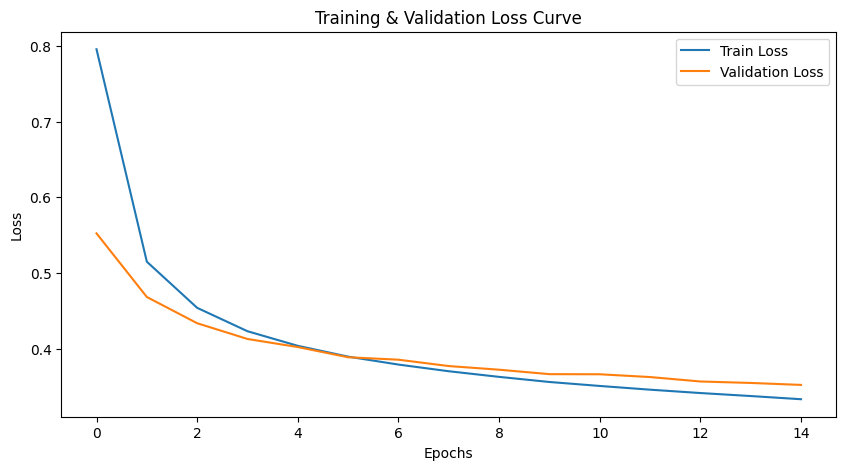

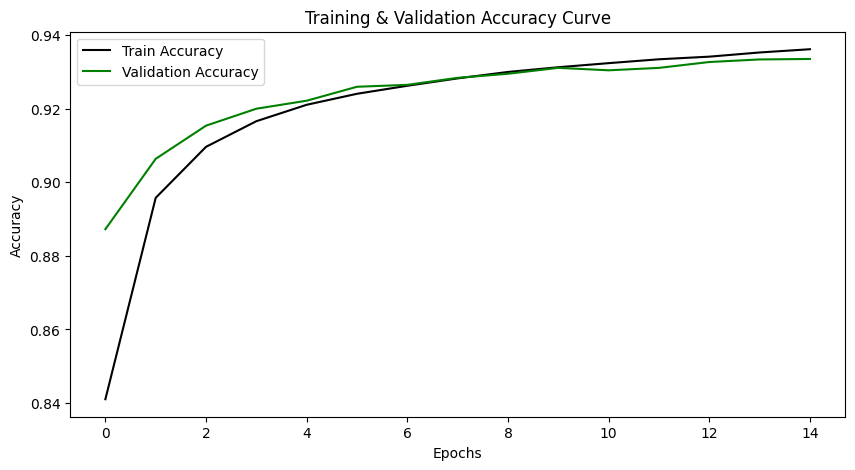

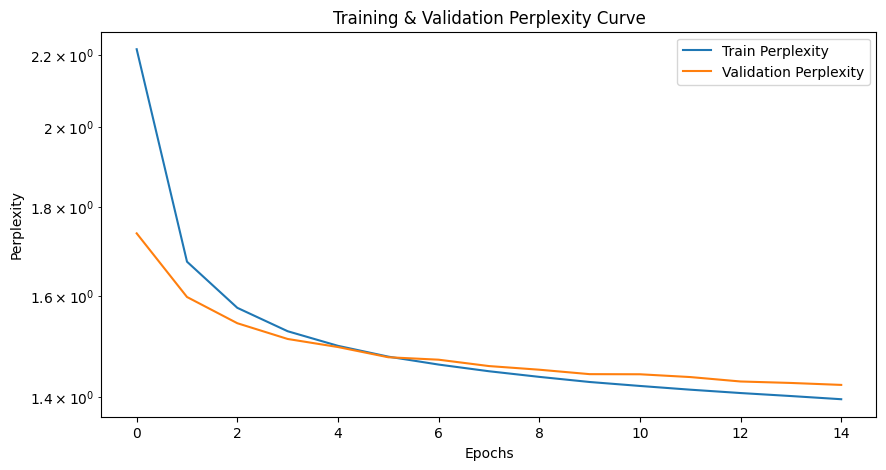

In [ ]:
# Plot Training & Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training & Validation Loss Curve")
plt.show()

# Plot Training & Validation Accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label="Train Accuracy", color="black")
plt.plot(val_accuracies, label="Validation Accuracy", color="green")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training & Validation Accuracy Curve")
plt.show()

# Plot Training & Validation Perplexity
plt.figure(figsize=(10, 5))
plt.plot(train_perplexities, label="Train Perplexity")
plt.plot(val_perplexities, label="Validation Perplexity")
plt.xlabel("Epochs")
plt.ylabel("Perplexity")
plt.yscale("log")  # Log scale for better visualization
plt.legend()
plt.title("Training & Validation Perplexity Curve")
plt.show()

In [10]:
def predict_next_token(model, tokenizer, text, top_k=5):
    model.eval()
    tokens = tokenizer.encode(text).ids
    #print(tokenizer.encode(text).tokens)
    #print(tokens)
    input_tensor = torch.tensor([tokens]).to(device)

    with torch.no_grad():
        output = model(input_tensor)
        predicted_id = torch.topk(output, k=top_k).indices.cpu().numpy()

    # Return the predicted next token(s)
    return [tokenizer.decode([idx]) for idx in predicted_id[0]]


In [11]:
def model_testing(model, tokenizer, test_cases, top_k=5):
    total_correct = 0
    total_predictions = 0

    # Loop through each test case
    for input_text, true_output in test_cases:
        predicted_tokens = predict_next_token(model, tokenizer, input_text, top_k)
        print(f"Input: {input_text}")
        print(f"Predicted: {predicted_tokens}")
        print(f"True Output: {true_output}")

        # Compare the first predicted token with the ground truth
        if predicted_tokens[0] == true_output:
            total_correct += 1
        total_predictions += 1

    # Calculating  testing accuracy
    accuracy = total_correct / total_predictions
    print(f"Total Correct Predictions: {total_correct}/{total_predictions}")
    print(f"Accuracy: {accuracy * 100:.2f}%")

In [16]:
# Example test cases: [(input_text, true_output)]

test_cases = [
       #0005_added_link_to_object.py
       ("def my_sum(a,b): return a","."),
       ("db.add_column('mailchimp_campaign', 'object_id',","self"),
       ("def backwards(self,","orm"),
       #0005_auto__add_field_dataset_typed_columns.py
       ("'id': ('django.db.models.fields.AutoField', [], {'","primary_key"),
       ("'is_staff': ('django.db.models.fields.BooleanField', [], {'","default"),
       #0005_rename_get_case_attachment_by_name.py
       ("db.add_column('links_link', 'description_as_html', self.gf('django.db.","models"),
       ("db.add_column('links_link', 'description_as_html', self.gf('django.db.models.fields.","TextField"),
       ("db.alter_column('links_link', 'description', self.gf('django.db.models.fields.TextField')(null=","True")

]

# Evaluate the model
model_testing(model, tokenizer, test_cases)

Input: def my_sum(a,b): return a
Predicted: [',', '(', 'if', 'b', '1']
True Output: .
Input: db.add_column('mailchimp_campaign', 'object_id',
Predicted: ['self', "'", 'None', "('", 'models']
True Output: self
Input: def backwards(self,
Predicted: ['orm', 'self', 'True', 'None', 'models']
True Output: orm
Input: 'id': ('django.db.models.fields.AutoField', [], {'
Predicted: ['primary_key', 'to', 'max_length', 'True', 'blank']
True Output: primary_key
Input: 'is_staff': ('django.db.models.fields.BooleanField', [], {'
Predicted: ['default', 'max_length', 'symmetrical', 'primary_key', 'unique']
True Output: default
Input: db.add_column('links_link', 'description_as_html', self.gf('django.db.
Predicted: ['models', 'fields', 'gf', 'PositiveIntegerField', 'db']
True Output: models
Input: db.add_column('links_link', 'description_as_html', self.gf('django.db.models.fields.
Predicted: ['TextField', 'CharField', 'PositiveIntegerField', 'BooleanField', 'FloatField']
True Output: TextField
Input: db